CS 634 Final Project by Shan Wu

1 Final Project - Data Mining

2. Using Random Forest, SVM and LSTM to Predict Credit Default

2.1 Goal
“My project aims to implement a variety of machine learning classification algorithms, along with
a deep learning model, to predict the likelihood of a credit default. This prediction is
based on credit related information provided in the dataset.”

2.1.1 Importing the packages and libraries that are required for the project

In [7]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
import openml
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_predict, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import auc

2.1.2 Loading Data And Preprocessing

Link to the data description: https://www.openml.org/search?type=data&status=active&id=43978

In [2]:
X, y = fetch_openml('credit', version=1, return_X_y=True)
#X = X_df.to_numpy()  # Convert DataFrame to numpy array
#y = y_df.to_numpy() 
X.describe(), y.describe()

(       RevolvingUtilizationOfUnsecuredLines           age  \
 count                          16714.000000  16714.000000   
 mean                               4.799862     48.798672   
 std                              204.062345     13.906078   
 min                                0.000000     21.000000   
 25%                                0.082397     38.000000   
 50%                                0.443080     48.000000   
 75%                                0.926637     58.000000   
 max                            22000.000000    101.000000   
 
        NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  MonthlyIncome  \
 count                          16714.000000  16714.000000   16714.000000   
 mean                               1.110267     30.980298    6118.120258   
 std                                7.172890    719.694859    5931.841779   
 min                                0.000000      0.000000       0.000000   
 25%                                0.000000      0.155

2.1.4 Data Visualizaiton

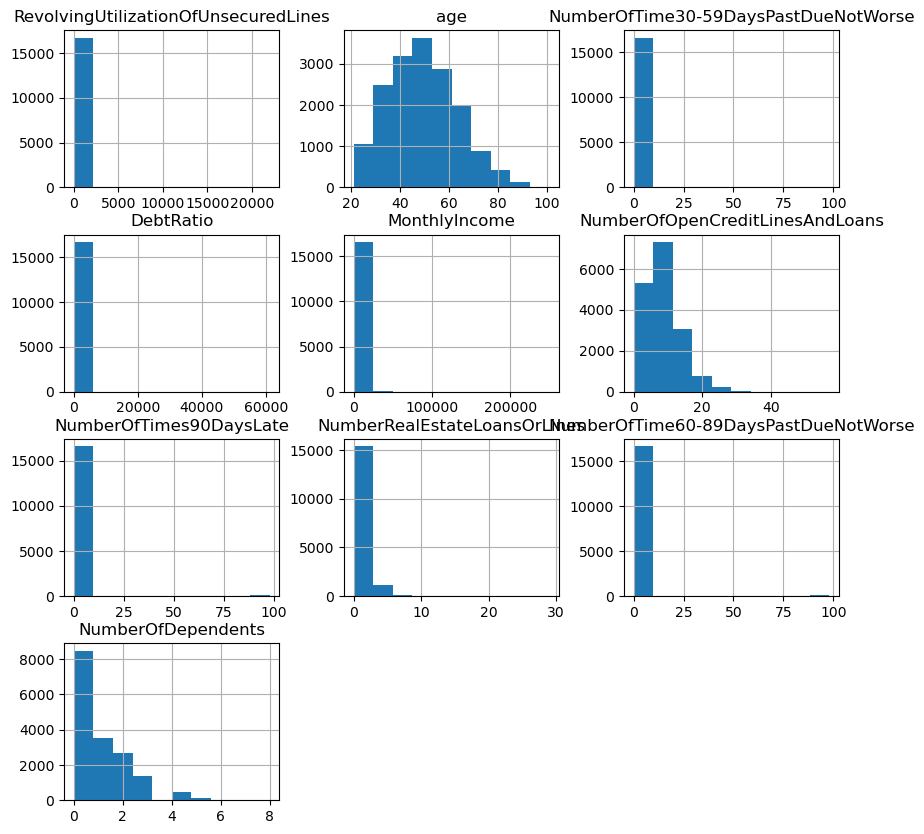

In [5]:
# Creating a correlation matrix and displaying it using a heatmap
X.hist(figsize=(10, 10))
plt.show()

2.2.1 create functions for metrics

In [3]:
def calc_metrics(confusion_matrix):
    TP, FN = confusion_matrix[0][0], confusion_matrix[0][1]
    FP, TN = confusion_matrix[1][0], confusion_matrix[1][1]
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (TN + FP)
    FNR = FN / (TP + FN)
    Precision = TP / (TP + FP)
    F1_measure = 2 * TP / (2 * TP + FP + FN)
    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Error_rate = (FP + FN) / (TP + FP + FN + TN)
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    metrics = [TP, TN, FP, FN, TPR, TNR, FPR, FNR, Precision, F1_measure, Accuracy, Error_rate, BACC, TSS, HSS]
    return metrics
def get_metrics(model, X_train, X_test, y_train, y_test, LSTM_flag):
    def calc_metrics(confusion_matrix):
        TP, FN = confusion_matrix[0][0], confusion_matrix[0][1]
        FP, TN = confusion_matrix[1][0], confusion_matrix[1][1]
        TPR = TP / (TP + FN)
        TNR = TN / (TN + FP)
        FPR = FP / (TN + FP)
        FNR = FN / (TP + FN)
        Precision = TP / (TP + FP)
        F1_measure = 2 * TP / (2 * TP + FP + FN)
        Accuracy = (TP + TN) / (TP + FP + FN + TN)
        Error_rate = (FP + FN) / (TP + FP + FN + TN)
        BACC = (TPR + TNR) / 2
        TSS = TPR - FPR
        HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
        return [TP, TN, FP, FN, TPR, TNR, FPR, FNR, Precision, F1_measure, Accuracy, Error_rate, BACC, TSS, HSS]

    metrics = []
        
    if LSTM_flag == 1:
        # Convert data to numpy array
        Xtrain, Xtest, ytrain, ytest = map(np.array, [X_train, X_test, y_train, y_test])
        # Reshape data
        shape = Xtrain.shape
        Xtrain_reshaped = Xtrain.reshape(len(Xtrain), shape[1], 1)
        Xtest_reshaped = Xtest.reshape(len(Xtest), shape[1], 1)
        model.fit(Xtrain_reshaped, ytrain, epochs=50,validation_data=(Xtest_reshaped, ytest), verbose=0)
        lstm_scores = model.evaluate(Xtest_reshaped, ytest, verbose=0)
        predict_prob = model.predict(Xtest_reshaped)
        pred_labels = predict_prob > 0.5
        pred_labels_1 = pred_labels.astype(int)
        matrix = confusion_matrix(ytest, pred_labels_1, labels=[1, 0])
        lstm_brier_score = brier_score_loss(ytest, predict_prob)
        lstm_roc_auc = roc_auc_score(ytest, predict_prob)
        metrics.extend(calc_metrics(matrix))
        metrics.extend([lstm_brier_score, lstm_roc_auc, lstm_scores[1]])
    elif LSTM_flag == 0:
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        matrix = confusion_matrix(y_test, predicted, labels=[1, 0])
        model_brier_score = brier_score_loss(y_test, model.predict_proba(X_test)[:, 1])
        model_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        metrics.extend(calc_metrics(matrix))
        metrics.extend([model_brier_score, model_roc_auc, model.score(X_test, y_test)])
    return metrics

2.2.2 Calculate metrics with the 3 methods

In [5]:
# Define Stratified K-Fold cross-validator
cv_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)
# Initialize metric columns
metric_columns = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'F1_measure', 'Accuracy', 'Error_rate', 'BACC', 'TSS', 'HSS', 'Brier_score','AUC', 'Acc_by_package_fn']
# Initialize metrics lists for each algorithm
rf_metrics_list, knn_metrics_list, lstm_metrics_list = [], [], []
C = 1.0
# 10 Iterations of 10-fold cross-validation
for iter_num, (train_index, test_index) in enumerate(cv_stratified.split(X, y), start=1):
    # Random Forest Model
    rf_model = RandomForestClassifier(n_estimators=100)
    # KNN Classifier Model
    knn_model = KNeighborsClassifier()
    # LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(64, activation='relu', return_sequences=False))
    lstm_model.add(Dense(1, activation='sigmoid'))
    # Compile model
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    # Get metrics for each algorithm
    rf_metrics = get_metrics(rf_model, X_train, X_test, y_train, y_test, 0)
    knn_metrics = get_metrics(knn_model, X_train, X_test,y_train, y_test, 0)
    lstm_metrics = get_metrics(lstm_model, X_train, X_test,y_train, y_test, 1)
    # Append metrics to respective lists
    rf_metrics_list.append(rf_metrics)
    knn_metrics_list.append(knn_metrics)
    lstm_metrics_list.append(lstm_metrics)
    # Create a DataFrame for all metrics
    metrics_all_df = pd.DataFrame([rf_metrics, knn_metrics,lstm_metrics], columns=metric_columns, index=['RF','KNN', 'LSTM'])
    # Display metrics for all algorithms in each iteration
    print('\nIteration {}: \n'.format(iter_num))
    print('\n----- Metrics for all Algorithms in Iteration {} -----\n'.format(iter_num))
    print(metrics_all_df.round(decimals=2).T)
    print('\n')

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Iteration 1: 


----- Metrics for all Algorithms in Iteration 1 -----

                       RF     KNN    LSTM
TP                 632.00  418.00  626.00
TN                 649.00  497.00  626.00
FP                 187.00  339.00  210.00
FN                 204.00  418.00  210.00
TPR                  0.76    0.50    0.75
TNR                  0.78    0.59    0.75
FPR                  0.22    0.41    0.25
FNR                  0.24    0.50    0.25
Precision            0.77    0.55    0.75
F1_measure           0.76    0.52    0.75
Accuracy             0.77    0.55    0.75
Error_rate           0.23    0.45    0.25
BACC                 0.77    0.55    0.75
TSS                  0.53    0.09    0.50
HSS                  0.53    0.09    0.50
Brier_score          0.16    0.29    0.17
AUC                  0.84    0.56    0.83
Acc_by_package_fn    0.77    0.55    0.75


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Iteration 2: 


----- Metrics for all Algorithms 

2.2.3 Evaluating the performance of various algorithms by comparing their ROC curves and AUC scores on the test dataset.

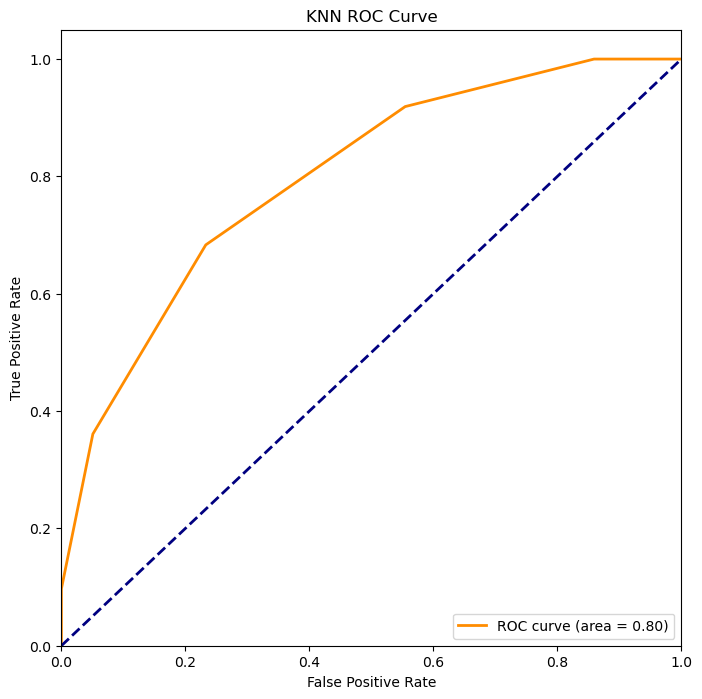

In [8]:
# KNN Model
knn_model = KNeighborsClassifier()
knn_model.fit(X, y)
# Obtain predicted probabilities
y_score = knn_model.predict_proba(X)[:, 1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc='lower right')
plt.show()

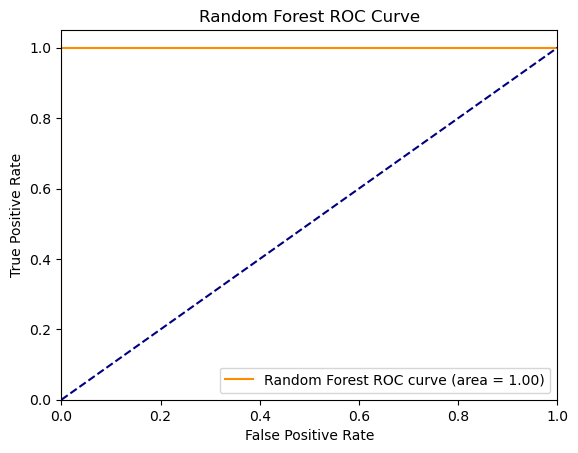

In [10]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X, y)
# Obtain predicted probabilities
y_score_rf = rf_model.predict_proba(X)[:, 1]
# Compute ROC curve and ROC area
fpr_rf, tpr_rf, _ = roc_curve(y, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
# Plot Random Forest ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange", label="Random Forest ROC curve (area = {:.2f})".format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()

523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


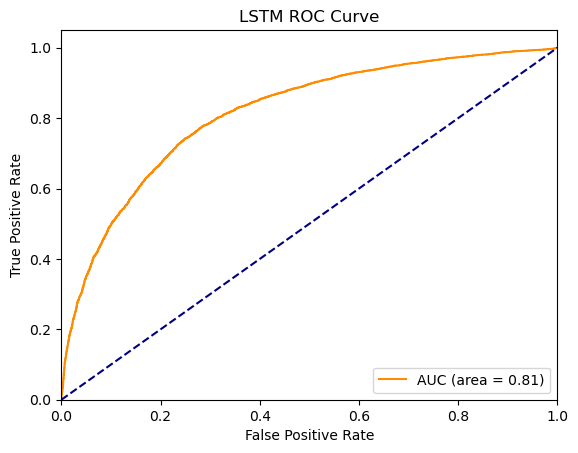

In [11]:
# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', return_sequences=False))
lstm_model.add(Dense(1, activation='sigmoid'))
# Compile model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert data to numpy array
X_train_array = X.to_numpy()
X_test_array = X.to_numpy()
y_train_array = y.to_numpy()
y_test_array = y.to_numpy()
# Reshape data
input_shape = X_train_array.shape
input_train = X_train_array.reshape(len(X_train_array), input_shape[1], 1)
input_test = X_test_array.reshape(len(X_test_array), input_shape[1], 1)
output_train = y_train_array
output_test = y_test_array
# Train the LSTM model
lstm_model.fit(input_train, output_train, epochs=50,validation_data=(input_test, output_test), verbose=0)
# Predict probabilities for the test set
predict_lstm = lstm_model.predict(input_test)
# Compute ROC curve and ROC area
fpr_lstm, tpr_lstm, _ = roc_curve(y, predict_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
# Plot LSTM ROC curve
plt.figure()
plt.plot(fpr_lstm, tpr_lstm, color="darkorange", label="AUC (area = {:.2f})".format(roc_auc_lstm))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.legend(loc="lower right")
plt.show()

2.3 Compare all models

In [16]:
# Initialize metric index for each iteration
metric_index_df = ['iter1', 'iter2', 'iter3', 'iter4', 'iter5', 'iter6','iter7', 'iter8', 'iter9', 'iter10']
# Create DataFrames for each algorithm's metrics
knn_metrics_df = pd.DataFrame(knn_metrics_list, columns=metric_columns, index=metric_index_df)
rf_metrics_df = pd.DataFrame(rf_metrics_list, columns=metric_columns,index=metric_index_df)
lstm_metrics_df = pd.DataFrame(lstm_metrics_list, columns=metric_columns,index=metric_index_df)
# Display metrics for each algorithm in each iteration
for i, metrics_df in enumerate([knn_metrics_df, rf_metrics_df, lstm_metrics_df], start=1):
    print('\nMetrics for Algorithm {}:\n'.format(i))
    print(metrics_df.round(decimals=2).T)
    print('\n')




Metrics for Algorithm 1:

                    iter1   iter2   iter3   iter4   iter5   iter6   iter7  \
TP                 418.00  428.00  442.00  426.00  456.00  445.00  434.00   
TN                 497.00  510.00  524.00  517.00  511.00  528.00  530.00   
FP                 339.00  326.00  312.00  319.00  325.00  308.00  306.00   
FN                 418.00  408.00  394.00  410.00  379.00  390.00  401.00   
TPR                  0.50    0.51    0.53    0.51    0.55    0.53    0.52   
TNR                  0.59    0.61    0.63    0.62    0.61    0.63    0.63   
FPR                  0.41    0.39    0.37    0.38    0.39    0.37    0.37   
FNR                  0.50    0.49    0.47    0.49    0.45    0.47    0.48   
Precision            0.55    0.57    0.59    0.57    0.58    0.59    0.59   
F1_measure           0.52    0.54    0.56    0.54    0.56    0.56    0.55   
Accuracy             0.55    0.56    0.58    0.56    0.58    0.58    0.58   
Error_rate           0.45    0.44    0.42    0.44

In [17]:
# Calculate the average metrics for each algorithm
knn_avg_df = knn_metrics_df.mean()
rf_avg_df = rf_metrics_df.mean()
lstm_avg_df = lstm_metrics_df.mean()
# Create a DataFrame with the average performance for each algorithm
avg_performance_df = pd.DataFrame({'KNN': knn_avg_df, 'RF': rf_avg_df, 'LSTM': lstm_avg_df}, index=metric_columns)

print(avg_performance_df.round(decimals=2))
print('\n')

                      KNN      RF    LSTM
TP                 438.00  630.50  626.40
TN                 517.20  656.70  622.80
FP                 318.50  179.00  212.90
FN                 397.70  205.20  209.30
TPR                  0.52    0.75    0.75
TNR                  0.62    0.79    0.75
FPR                  0.38    0.21    0.25
FNR                  0.48    0.25    0.25
Precision            0.58    0.78    0.75
F1_measure           0.55    0.77    0.75
Accuracy             0.57    0.77    0.75
Error_rate           0.43    0.23    0.25
BACC                 0.57    0.77    0.75
TSS                  0.14    0.54    0.49
HSS                  0.14    0.54    0.49
Brier_score          0.27    0.16    0.17
AUC                  0.60    0.84    0.83
Acc_by_package_fn    0.57    0.77    0.75


